In [1]:
%reload_ext sql
%reload_ext mocodo

Mocodo 4.2.2 loaded.


In [3]:
%config SqlMagic.dsn_filename = "../connexion_BD.ini" 
# ajouter ou changer ce fichier pour définir sa connexion. Le fichier doit être de la forme
# [pg]
# drivername = postgresql+psycopg
# username = 
# password = 
# host = 
# port = 
# database = 
%sql --section pg
%config SqlMagic.displaylimit = 0 #pas de limite dans le nombre de tuples du résultat

Connecting to 'pg'

# TP : Implémentation de contraintes

***Important : tout au long du TP, faites des tests de vos contraintes en insérant, supprimant, modifiant des tuples***

Un club de danse souhaite se doter d'une base de données pour gérer ses intervenants dans les cours.
Après analyse, on propose le schéma Entités/Associations ci-dessous. Les niveaux des cours sont à prendre parmi les valeurs 'Débutant', 'Avancé' ou 'Expert'.

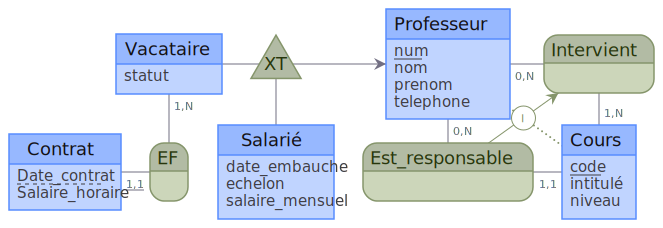

In [14]:
%%mocodo --select mcd --colors ocean  --output_dir ./ -t arrange

Professeur: num, nom,prenom, telephone
Salarié: date_embauche, echelon, salaire_mensuel
Vacataire: statut
Cours: code, intitulé, niveau
Contrat : Date_contrat, Salaire_horaire

Est_responsable, 0N Professeur, 11 Cours
Intervient, 0N professeur, 1N Cours
EF, _11 Contrat, 1N Vacataire

/XT\ Professeur <- Vacataire, Salarié
(I) -> Intervient, ..Professeur, ..Cours, --Est_responsable

1. Traduisez ce schéma en relationnel ; en ne tenant pas compte pour l'instant des contraintes $XT$ et $I$. Créez les relations obtenues, ainsi que les clés et clés étrangères qui en découlent.
- indication 1 : Puisque qu'un cours a **exactement** un responsable, cette association se traduira par une clé étrangère dans la relation "Cours", ne pouvant prendre la valeur NULL.
- indication 2 : Les spécialisations et entités faibles induisent une contrainte d'existence ; par exemple, supprimer un professeur de la base induit de le supprimer également en tant que salarié ou vacataire. De même supprimer un vacataire, induit de supprimer les contrats qui s'y rapportent. Faites en sorte que toutes ces suppressions en cascade soient automatiques (option : ON DELETE CASCADE des clés étrangères).

In [ ]:
#le script de création est dans l'espace WEB accessible aux étudiants.
with open("../../TP/script_club_de_danse.sql","r") as fichier:
    %sql {{fichier.read()}}


2. La contrainte $I$ sur le schéma traduit le fait que si un professeur est responsable d'un cours, alors il intervient dans ce cours. C'est une implication/inclusion : tout couple (professeur, cours) de l'association "Responsable" doit exister dans l'association "Intervient".
   1. Écrivez la dépendance d'inclusion qui traduit cette contrainte dans la base de données
   2. Cette dépendance d'inclusion peut-elle être implantée par une clé étrangère dans la relation 'cours' ?
   3. Créez cette contrainte dans la base de données.
   4. Créez un professeur "Jean Wiejacka" (sans se soucier encore qu'il soit vacataire ou salarié). Créez un cours de salsa débutant, pour lequel Jean Wiejacka est le responsable. Quel problème rencontrez vous ?

In [ ]:
%%sql

-- Cette contrainte est une dépendance d'inclusion Cours[NumProfResponsable, CodeCours] "inclus dans" Intervient[NumProf, CodeCours]
-- Elle exprime une clé étrangère dans "Cours", car la partie droite est une clé dans "Intervient".

alter table cours add constraint fk_resp_intervient foreign key(numresponsable_cours,code_cours) references prof_intervient_cours(num_prof, code_cours);


In [ ]:
%%sql

-- création de Jean Wiejacka professeur de salsa
insert into professeurs values (1,'Wiejacka','Jean','0638103978');

In [ ]:
%%sql
-- tentative de création du cours de SALSA, qui doit obligatoirement avoir un responsable
 insert into cours values(1,'Salsa',1, 'Débutant'); -- Jean est le responsable de la salsa.

-- Ne fonctionne pas (contrainte 'fk_resp_intervient' de la question précédente) : 
-- le couple (1,1) doit exister dans intervient (Jean DOIT donner des cours de salsa pour être responsable)

In [ ]:
%%sql 

insert into prof_intervient_cours values(1,1);

-- Evidemment ne fontionne pas puisque le cours 1 n'existe pas...

-- blocage par des clés étrangères qui forment un cycle...


3. Une transaction est un ensemble de mises à jour considérées comme une seule opération, sans limite sur le nombre d'opérations dans une même transaction. Les SGBD relationnels garantissent que les contraintes sont satisfaites AVANT et APRES la transaction. Ce qui se passe PENDANT la transaction dépend des capacités des SGBD et des choix de l'opérateur. La vérification de certaines contraintes, comme les clés étrangères sous PostgreSQL, peut être *différée* à l'issue de la transaction.
   1. Modifiez, lorsque cela est nécessaire, les déclarations de clés étrangères afin de différer leur vérification en fin de transaction.
   2. Procédez maintenant à la création du cours de SALSA à l'aide d'une transaction contenant plusieurs insertions de tuples.

In [ ]:
%%sql

-- Pour casser le cycle, on permet de différer la clé étrangère qu'on a créée sur "Cours" :

alter table cours alter constraint fk_resp_intervient deferrable; 


In [ ]:
%%sql

--On peut maintenant faire l'insertion en deux temps au sein d'une seule et même transaction :


begin;
    set constraints fk_resp_intervient deferred; -- Cette contrainte a bien été déclarée comme déférable
    insert into cours values(1,'Salsa',1, 'Débutant'); -- Jean est le responsable de la salsa. fk_resp_intervient est momentanément
    -- fausse, mais la transaction n'est pas finie.
    insert into prof_intervient_cours values(1,1);
commit; -- ici la contrainte différée est vérifiée, tout est OK.

4. Le cahier des charges spécifie qu'un cours a obligatoirement (au moins) un intervenant (participation obligatoire à l'association "Intervient").  Peut-on considérer que cette contrainte est bien garantie dans notre base de données ?

In [ ]:
%%sql

-- Chaque cours doit avoir au moins un intervenant...
-- On voudrait une dépendance d'inclusion cours[code_cours] "inclus dans" prof_intervient_cours[code_cours]
-- Car tous les cours doivent être dans "intervient" au moins une fois.

-- Cette DI est déjà implémentée ! En effet, 
-- on a cours[numresponsable_cours, code_cours] "inclus dans" prof_intervient_cours[num_prof, code_cours] vu précédemment, 
-- donc cours[code_cours] "inclus dans" prof_intervient_cours[code_cours] est une conséquence de la première.
-- c'est la règle de projection dans les DI, pas encore vue mais facile à comprendre intuitivement.

5. Implanter la contrainte $X$ indiquée dans la spécialisation des professeurs, indiquant qu'un professeur ne peut pas être à la fois un salarié et un vacataire.
-  **Indication** : Cette contrainte peut se programmer à l'aide de deux commandes "CHECK" dans la déclaration des relations "salaries" et "vacataires", par exemple sous la forme "Check (est\_vacataire(num\_prof) = false)" - où "est\_vacataire(num\_prof)" est une fonction qui retourne vrai si "num\_prof" existe déjà dans vacataires, faux sinon.

Voici pour servir d'exemple une proposition de code de création d'une fonction qui renvoie VRAI ssi le numéro passé en argument est celui d'un vacataire.

```sql
drop function if exists est_vacataire;
CREATE function est_vacataire(un_num_prof integer) returns boolean
as $$
begin
 	perform num_vacataire  
 	from vacataires 
 	where num_vacataire = un_num_prof;
 
 	return (found);
end;
 $$ language plpgsql;

```

In [ ]:
%%sql

-- création d'une fonction qui teste si un prof est dans les vacataires

drop function if exists est_vacataire;
CREATE function est_vacataire(un_num_prof integer) returns boolean
as $$
begin
 	perform num_vacataire  
 	from vacataires 
 	where num_vacataire = un_num_prof;
 
 	return (found);
end;
 $$ language plpgsql;

In [ ]:
%%sql

-- création d'une fonction qui teste si un prof est dans les salariés

drop function if exists est_salarie;
CREATE function est_salarie(un_num_prof integer) returns boolean
as $$
begin
 	perform num_salarie  
 	from salaries
 	where num_salarie = un_num_prof;
 
 	return (found);
end;
 $$ language plpgsql;

In [ ]:
%%sql

-- On peut maintenant ajouter des contraintes CHECK dans les relations salarie et vacataires
-- Pour garantir l'exclusion mutuelle à l'insertion / modification

alter table salaries add constraint ck_non_vacataire CHECK(est_vacataire(num_salarie)=false);
alter table vacataires add constraint ck_non_salarie CHECK(est_salarie(num_vacataire)=false);

6. Implanter la contrainte $T$ de la spécialisation, qui impose que tous les professeurs ont la position de salarié ou de vacataire.    
   1. Lors de la création d'un professeur : ajouter une contrainte "check" qui s'assure que ce professeur est bien un salarié ou un vacataire. 
   2. Différez les contraintes de clés étrangères dans "salariés" et "vacataires", de façon à pouvoir **momentanément** créer un salarié ou vacataire qui n'est pas un professeur.
   3. Effectuez alors l'insertion d'un nouveau professeur - vacataire dans une transaction qui crée d'abord le vacataire pour le professeur. 


In [ ]:
%%sql

alter table salaries alter constraint fk_sal_prof deferrable;
alter table vacataires alter constraint fk_vac_prof deferrable;

-- Au préalable dans les données saisies on indique que le professeur 1 est salarié pour ne pas violer la contrainte déclarée après
insert into salaries values(1,'2022-07-10',2,1500);

alter table professeurs add constraint ck_prof_sal_ou_vac check(est_vacataire(num_prof) or est_salarie(num_prof));

begin;
	set constraints all deferred;
	insert into vacataires values(2,'sans emploi'); -- possible par la clé étrangère différée
	insert into professeurs values(2,'Vanessa','Geluk','0472983719'); -- possible car existe parmi les vacataires
commit;


7. Ce n'est pas tout à fait fini ! Il faut encore s'assurer que personne ne puisse supprimer une ligne des relations "vacataires" ou "salariés" car cela contredirait la contrainte $T$ (un professeur serait ni salarié, ni vacataire). Mais si on fait une contrainte trop forte qui interdit ces suppressions, on ne pourra plus faire les opérations suivantes : modifier un professeur en le passant de vacataire à salarié (ou l'inverse), ou même supprimer un professeur - car Postgre va tenter de supprimer le vacataire/salarié correspondant (en cascade). Voici comment résoudre ces problèmes.
   1. Créer une fonction $est\_prof$ qui teste si un numéro de professeur (fourni en entrée) existe parmi les professeurs. 
   2. Faire un trigger (https://doc.postgresql.fr/16/sql-createtrigger.html) différable sur "salaries" qui interdit de supprimer un salarié si celui est un professeur qui existe encore et qu'il n'est pas dans "vacataires".
   3. Faire un trigger différable sur "vacataires" qui interdit de supprimer un vacataire si celui est un professeur qui existe encore et qu'il n'est pas dans "salaries".
   4. Vérifiez maintenant que vous pouvez 1) supprimer un professeur et 2) passer un professeur de salarié à vacataire en utilisant une transaction à deux étapes.


Aide : comment faire le trigger sur salariés :

```sql
-- Il faut d'abord faire une fonction qui sera utilisée par le trigger : elle ne doit pas prendre de paramètres, et retourner un objet de type 'trigger'.
drop function if exists check_prof_vacataire cascade; 
CREATE FUNCTION check_prof_vacataire() RETURNS trigger 
as $$
begin
	if  not est_prof(old.num_salarie) then return null; -- le prof a été supprimé (en cours de suppression)
	elsif est_vacataire(old.num_salarie) then return null; -- le salarié est bien dans vacataires.
	else raise exception 'professeur doit etre vacataire si plus salarie';
	end if;
end;
$$ LANGUAGE plpgsql;

create constraint trigger check_prof_vacataire
	after delete or update on salaries deferrable for each row execute function check_prof_vacataire();


```

In [ ]:
%%sql

drop function if exists est_prof;
CREATE function est_prof(un_num_prof integer) returns boolean
as $$
begin
 	perform num_prof  
 	from professeurs 
 	where num_prof = un_num_prof;
 
 	return (found);
end;
 $$ language plpgsql;



In [ ]:
%%sql

-- Interdiction de supprimer un salarié s'il n'est pas vacataire.
-- Contrainte forcément différable car il faut pouvoir avant l'insérer dans vacataire 

drop function if exists check_prof_vacataire cascade; 
CREATE FUNCTION check_prof_vacataire() RETURNS trigger 
as $$
begin
	if  not est_prof(old.num_salarie) then return null; -- le prof a été supprimé (en cours de suppression)
	elsif est_vacataire(old.num_salarie) then return null; -- le salarié est bien dans vacataires.
	else raise exception 'professeur doit etre vacataire si plus salarie';
	end if;
end;
$$ LANGUAGE plpgsql;

create constraint trigger check_prof_vacataire
	after delete or update on salaries deferrable for each row execute function check_prof_vacataire();


In [ ]:
%%sql

-- Interdiction de supprimer un vacataire s'il n'est pas salarié.
-- Contrainte forcément différable car il faut pouvoir avant l'insérer dans salaries. 
drop function if exists check_prof_salarie cascade; 
CREATE FUNCTION check_prof_salarie() RETURNS trigger 
as $$
begin
	if not est_prof(old.num_vacataire) then return null; -- le prof a été supprimé (essentiel pour pouvoir supprimer un prof)
	elsif est_salarie(old.num_vacataire) then return null; -- le prof est bien dans salarié.
	else raise exception 'professeur doit etre salarie si plus vacataire';
	end if;
end;
$$ LANGUAGE plpgsql;

create constraint trigger check_prof_salarie
	after delete or update on vacataires deferrable for each row execute function check_prof_salarie();


In [ ]:
%%sql

-- on transforme le professeur 1 en vacataire étudiant (il était salarié)
begin;
	set constraints all deferred ;
	delete from salaries where num_salarie=1; -- momentanément ni vacataire ni salarié, mais la contrainte est différée
	insert into vacataires values(1,'étudiant');
commit;

In [ ]:
%%sql

-- on vérifie que la suppression d'un professeur fonctionne toujours

delete from professeurs where num_prof=2;

In [ ]:
%%sql

select * 
from professeurs p  
     left join vacataires v on p.num_prof=v.num_vacataire
     left join salaries s on p.num_prof = s.num_salarie;

